# Image Segmentation with Tensorflow using Unet

## Use Case :
 
Remote Sensing Application using Tensorflow

Image segmenation helps to know location of specific object by classifying each pixel in the image. You have been seen image classification which tells the class of the image based on the labels trained in the network. In this case each pixel of image allocates a label and inputs as mask image for training.

#### DATASET:
Current use case was being developed using the data set "Inria Aerial Image Labeling Dataset" https://project.inria.fr/aerialimagelabeling/.

### Installation required to get pix2pix

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-0iukjo2f
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-0iukjo2f
  Created wheel for tensorflow-examples: filename=tensorflow_examples-7dc0a0bd1fb1fcc1d2488aeb999f73c5808b8f34_-cp37-none-any.whl size=265844 sha256=32c307556a1fa859edb6d0a224a8a5f4a4d33053047eb594d72f4ee0fb52b2e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qc61zmh/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


### Import required packages

In [2]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/MyDrive/CNN_GAN/ImageSegmentation")

!ls

 AerialImageDataset			  pix2pix
'Copy of RS_SI_ImageSegmentation.ipynb'   RS_SI_ImageSegmentation.ipynb
 model.png				  unet.jpg


In [4]:
import os
import cv2
import numpy as np

import tensorflow as tf

from pix2pix import pix2pix

from IPython.display import clear_output

import matplotlib.pyplot as plt

### Read the train Images and its masks

In [5]:
# Reading images
NumTrainImags=10
NumTestImags=10
resize=320

# Train Set: Image and Mask (Ground Truth)
TRAIN_IMAGE_DIR_PATH = 'AerialImageDataset/train/images'
TRAIN_MASK_DIR_PATH = 'AerialImageDataset/train/gt'

# create list of PATHS
train_image_paths = [os.path.join(TRAIN_IMAGE_DIR_PATH, x) for x in sorted(os.listdir(TRAIN_IMAGE_DIR_PATH)) if x.endswith('.tif')]
train_mask_paths = [os.path.join(TRAIN_MASK_DIR_PATH, x) for x in sorted(os.listdir(TRAIN_MASK_DIR_PATH)) if x.endswith('.tif')]

train_img_data_list=[]
for img in train_image_paths[:NumTrainImags]:
        train_input_img=cv2.imread(img)
        train_input_img_resize=cv2.resize(train_input_img,(resize, resize))
        train_img_data_list.append(train_input_img_resize)
      
train_mask_data_list=[]
for img in train_mask_paths[:NumTrainImags]:
        train_mask_img=cv2.imread(img)
        train_mask_img_resize=cv2.resize(train_mask_img,(resize, resize))
        train_mask_img_resize=cv2.cvtColor(train_mask_img_resize, cv2.COLOR_BGR2GRAY)
        train_mask_data_list.append(train_mask_img_resize)

### Read the test Images and its masks

In [6]:
# Test Set: Image and Mask (Ground Truth)
TEST_IMAGE_DIR_PATH = 'AerialImageDataset/test/images'
TEST_MASK_DIR_PATH = 'AerialImageDataset/test/gt'

# create list of PATHS
test_image_paths = [os.path.join(TEST_IMAGE_DIR_PATH, x) for x in sorted(os.listdir(TEST_IMAGE_DIR_PATH)) if x.endswith('.tif')]
test_mask_paths = [os.path.join(TEST_MASK_DIR_PATH, x) for x in sorted(os.listdir(TEST_MASK_DIR_PATH)) if x.endswith('.tif')]

test_img_data_list=[]
for img in test_image_paths[:NumTestImags]:
        test_input_img=cv2.imread(img)
        test_input_img_resize=cv2.resize(test_input_img,(resize, resize))
        test_img_data_list.append(test_input_img_resize)
      
test_mask_data_list=[]
for img in test_mask_paths[:NumTestImags]:
        test_mask_img=cv2.imread(img)
        test_mask_img_resize=cv2.resize(test_mask_img,(resize, resize))
        test_mask_img_resize=cv2.cvtColor(test_mask_img_resize, cv2.COLOR_BGR2GRAY)
        test_mask_data_list.append(test_mask_img_resize)

### Convert to numpy array and datatype to float32

In [7]:
#Train Set
train_img_data = np.array(train_img_data_list)
train_img_data = train_img_data.astype('float32')

train_mask_data = np.array(train_mask_data_list)
train_mask_data = train_mask_data.astype('float32')
train_mask_data = train_mask_data[..., np.newaxis]

# Test Set
test_img_data = np.array(test_img_data_list)
test_img_data = test_img_data.astype('float32')

test_mask_data = np.array(test_mask_data_list)
test_mask_data = test_mask_data.astype('float32')
test_mask_data = test_mask_data[..., np.newaxis]

### Get the shape of train and test Images

In [8]:
print(train_img_data.shape)
print(train_mask_data.shape)
print(test_img_data.shape)
print(test_mask_data.shape)

(10, 320, 320, 3)
(10, 320, 320, 1)
(2, 320, 320, 3)
(2, 320, 320, 1)


### View the sample original image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(train_img_data_list[0])
plt.show()

### View the sample mask image

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(train_mask_data_list[0])
plt.show()

### Define the required training Variables

In [ ]:
TRAIN_LENGTH = NumTrainImags
BATCH_SIZE = 5
BUFFER_SIZE = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

### Define the required functions

In [ ]:
'''
This function is used to normalize the image and its masks
Input: Image and its mask
Output: Normalized Image and its masks
'''
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/resize - 1 
  input_mask = input_mask/255
  return input_image, input_mask

'''
This function is used to call the normalize function on train data
Input: Image and its mask
Output: Normalized Image and its masks
'''
@tf.function
def load_image_train(image, mask):
    
    image, mask = normalize(image, mask)

    return image, mask

'''
This function is used to normalize the image and its masks on test data
Input: Image and its mask
Output: Normalized Image and its masks
'''
def load_image_test(image, mask):

  image, mask = normalize(image, mask)

  return image, mask

### Using Tensorflow Dataset for the input pipeline

In [ ]:
# Create the tensorflow dataset using .from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_data, train_mask_data))

# Use the map function to apply the parallization
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# To shuffle the data
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# To define the Buffer size
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_dataset

### Apply the input pipeline for the test dataset

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_data, test_mask_data))
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().batch(1)

test_dataset

### Define the function to display the Image,mask and its prediction

In [ ]:
'''
This function is used to display the Image, mask and its predicted mask
Input: List of Image , mask and its predicted mask
Output: display of Image, mask and its predicted mask 
'''
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask = image, mask
display([sample_image[0], sample_mask[0]])

## Define the Unet Model 

In [ ]:
from IPython.display import Image
Image('unet.jpg')

### Define the upsampling layers

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[resize, resize, 3], include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 160, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 160, 160, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 160, 160, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

### Define the downsampling layers

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
OUTPUT_CHANNELS = 2

### Define the Unet model using upsampling and downsampling layers

In [ ]:
'''
This function is used to define the unet model
Input: no of output filteres
Output: Unet model 
'''
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[resize, resize, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Create the model and compile the model

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Function to reshape the predicted mask

In [ ]:
'''
This function is used to reshape the predicted masks 
Input: Predicted masks
Output: Reshaped predicted masks such that the last channel changes to 1 
'''
def create_mask(pred_mask):
    #Calling tf.argmax on with axis=-1 make the tensor loose the last channel 
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #This is added back as a singleton channel via tf.newaxis
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

### Function to predict the test image and display its predicted masks

In [ ]:
'''
This function is used to predict the test image and call the display function
Input: Test image
Output: display of Image, mask and its predicted mask 
'''
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0], sample_mask[0], create_mask(model.predict(sample_image))])

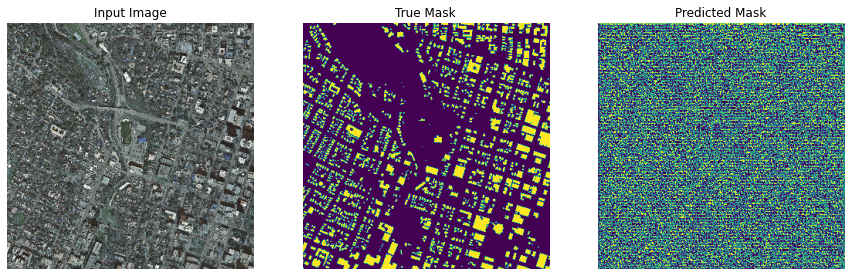

In [ ]:
show_predictions()

### Class to define the callback function which displays the predicted masks after each epoch

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### Train the model

In [ ]:
EPOCHS = 30

model_history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])

### Display the loss at each epoch

In [ ]:
loss = model_history.history['loss']
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Call the show_predictions function to display the test images, its masks and its predicted masks

In [ ]:
show_predictions(test_dataset, 10)